In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Tuple, Optional
from pathlib import Path
import architectures as arch
from functools import partial
from torchvision.ops import MLP
from bhpt_running import RefinementPipeline, Trainer
from architectures import SingleConvNeuralNet
import math
import time
import gc

# Import trim transformer
from trim_transformer.transformer_layers import CumulativeTransformerEncoderLayerKV, CumulativeTransformerEncoderKV

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Interactive environ: Jupyter themes not found.


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
def generate_cosine_dataset(
    n_samples: int,
    n_timesteps: int = 256,
    x_range: Tuple[float, float] = (0.0, 10.0),
    A_range: Tuple[float, float] = (0.5, 2.0),
    B_range: Tuple[float, float] = (0.5, 3.0),
    h_range: Tuple[float, float] = (-2.0, 2.0),
    k_range: Tuple[float, float] = (-1.0, 1.0),
    add_noise: bool = True,
    noise_std: float = 0.01
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate a synthetic dataset of cosine functions with random parameters.
    
    Args:
        n_samples: Number of samples to generate
        n_timesteps: Number of time points per sample
        x_range: Range of x values
        A_range: Range of amplitude values
        B_range: Range of frequency values
        h_range: Range of phase shift values
        k_range: Range of vertical shift values
        add_noise: Whether to add noise to the function values
        noise_std: Standard deviation of the noise
        
    Returns:
        waveforms: torch.Tensor of shape (N, T, 1, 1, 1) containing function values
        params: torch.Tensor of shape (N, 4) containing [A, B, h, k] for each sample
    """
    rng = np.random.default_rng(42)
    
    # Sample parameters uniformly
    A_values = rng.uniform(A_range[0], A_range[1], size=n_samples)
    B_values = rng.uniform(B_range[0], B_range[1], size=n_samples)
    h_values = rng.uniform(h_range[0], h_range[1], size=n_samples)
    k_values = rng.uniform(k_range[0], k_range[1], size=n_samples)
    
    # Create x values
    x = np.linspace(x_range[0], x_range[1], n_timesteps)
    
    # Generate waveforms
    waveforms = []
    for i in range(n_samples):
        # g(x) = A*cos(B*(x-h)) + k
        y = A_values[i] * np.cos(B_values[i] * (x - h_values[i])) + k_values[i]
        
        # Add noise if requested
        if add_noise:
            y += rng.normal(0, noise_std, size=n_timesteps)
        
        # Reshape to (T, 1, 1, 1) format
        y = y[:, None, None, None]
        waveforms.append(y.astype(np.float32))
    
    # Stack and convert to torch tensors
    waveforms_np = np.stack(waveforms, axis=0)  # (N, T, 1, 1, 1)
    params_np = np.stack([A_values, B_values, h_values, k_values], axis=1).astype(np.float32)  # (N, 4)
    
    return torch.from_numpy(waveforms_np), torch.from_numpy(params_np)

# Generate dataset
n_samples = 2048
n_timesteps = 256

print("Generating cosine function dataset...")
waveforms, params = generate_cosine_dataset(n_samples=n_samples, n_timesteps=n_timesteps)
print(f"Generated dataset shapes: waveforms {waveforms.shape}, params {params.shape}")
print(f"Parameter ranges: A=[{params[:, 0].min():.2f}, {params[:, 0].max():.2f}], "
      f"B=[{params[:, 1].min():.2f}, {params[:, 1].max():.2f}], "
      f"h=[{params[:, 2].min():.2f}, {params[:, 2].max():.2f}], "
      f"k=[{params[:, 3].min():.2f}, {params[:, 3].max():.2f}]")


Generating cosine function dataset...
Generated dataset shapes: waveforms torch.Size([2048, 256, 1, 1, 1]), params torch.Size([2048, 4])
Parameter ranges: A=[0.50, 2.00], B=[0.50, 3.00], h=[-2.00, 2.00], k=[-1.00, 1.00]


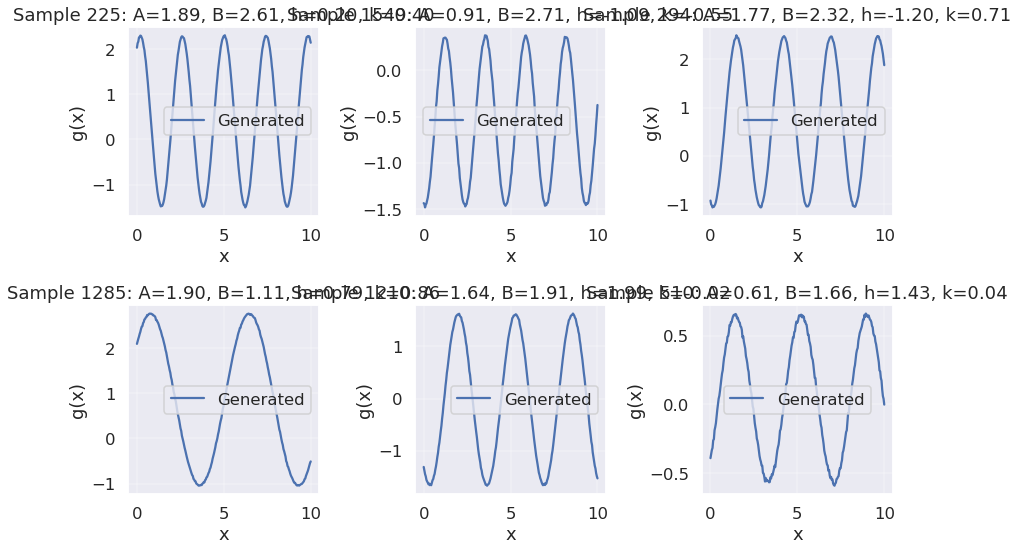

In [4]:
# Visualize some samples
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

x = np.linspace(0, 10, n_timesteps)

for i in range(6):
    idx = np.random.randint(0, n_samples)
    y = waveforms[idx, :, 0, 0, 0].numpy()
    A, B, h, k = params[idx].numpy()
    
    axes[i].plot(x, y, 'b-', label='Generated')
    axes[i].set_title(f'Sample {idx}: A={A:.2f}, B={B:.2f}, h={h:.2f}, k={k:.2f}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('g(x)')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()


In [5]:
# Create a custom dataset class for cosine functions
class CosineDataset(Dataset):
    """Dataset for cosine functions with conditional parameters."""
    def __init__(self, waveforms: torch.Tensor, params: torch.Tensor):
        super().__init__()
        assert waveforms.shape[0] == params.shape[0], "Number of waveforms and parameters must match"
        self.waveforms = waveforms
        self.params = params

    def __len__(self) -> int:
        return self.waveforms.shape[0]

    def __getitem__(self, idx: int):
        return self.waveforms[idx], self.params[idx]

# Setup data loaders
def setup_cosine_dataloaders(
    waveforms: torch.Tensor,
    params: torch.Tensor,
    batch_size: int,
    train_fraction: float = 0.8
):
    """Sets up DataLoaders for cosine function data."""
    dataset = CosineDataset(waveforms, params)
    n_train = int(len(dataset) * train_fraction)
    n_val = len(dataset) - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True),
    )

# Create dataloaders
batch_size = 32
train_loader, val_loader = setup_cosine_dataloaders(
    waveforms.to(device), 
    params.to(device), 
    batch_size=batch_size
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Training samples: 1638
Validation samples: 410
Batch size: 32
Training batches: 51
Validation batches: 12


In [6]:
import trim_transformer
# --- Model hyper-parameters --------------------------------------------------
d_model          = 512
nhead            = 8
dim_feedforward  = 1024
dropout          = 0.1
n_layers         = 16
n_params         = 4          # A, B, h, k
Q = 1
# ---------------------------------------------------------------------------

# ---------------------------------------------------------------------------
# Shared encoder and decoder (unchanged – included for context only)
# ---------------------------------------------------------------------------
encoder = SingleConvNeuralNet(
    dim=Q, hidden_dim=d_model, out_dim=d_model,
    K=[1,1], S=[1,1]
).to(device)

decoder = MLP(
    in_channels=d_model,
    hidden_channels=[d_model, d_model, Q],
    activation_layer=nn.GELU
).to(device)
# ---------------------------------------------------------------------------

# Positional encoding --------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position  = torch.arange(max_len).unsqueeze(1)
        div_term  = torch.exp(torch.arange(0, d_model, 2) *
                              (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))   # (1, max_len, d_model)

    def forward(self, x):                 # x shape (B, T, d_model)
        return self.dropout(x + self.pe[:, :x.size(1)])
# ---------------------------------------------------------------------------
pos_encoder = PositionalEncoding(d_model, dropout).to(device)

# Standard PyTorch transformer ----------------------------------------------
std_layer   = nn.TransformerEncoderLayer(
    d_model, nhead, dim_feedforward, dropout, batch_first=True)
model_standard = nn.TransformerEncoder(std_layer, n_layers).to(device)

# Trim-transformer -----------------------------------------------------------
trim_layer  = trim_transformer.transformer_layers.CumulativeTransformerEncoderLayerKV(
    d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
    dropout=dropout, batch_first=True)
model_trim  = trim_transformer.transformer_layers.CumulativeTransformerEncoderKV(
    encoder_layer=trim_layer, num_layers=n_layers).to(device)
# ---------------------------------------------------------------------------

In [7]:
class CosineRefinementPipeline(nn.Module):
    """
    Shared wrapper around the encoder-transformer-decoder stack.
    Adds:
      • broadcast_initial_conditions
      • sinusoidal positional encoding
      • *learned* projection of (A,B,h,k) onto the token dimension
    """
    def __init__(self, encoder, decoder, pos_enc, transformer, *, d_model):
        super().__init__()
        self.encoder      = encoder
        self.decoder      = decoder
        self.pos_enc      = pos_enc
        self.transformer  = transformer
        # ---- NEW: linear projection for the 4 conditioning parameters ----
        self.param_proj   = nn.Linear(n_params, d_model)
        # make Trainer happy
        self.model        = transformer

    def forward(self, x, params):
        """
        x      : (B, T, 1, 1, 1) – raw waveform
        params : (B, 4)          – [A, B, h, k]
        """
        # 0. broadcast first time-step (cosine value at t=0)
        x = arch.broadcast_initial_conditions(x)           # (B, T, 1, 1, 1)

        B, T, H, W, Q = x.shape
        S = H * W

        # 1. CNN encoder  → (B, T, H, W, d_model)
        y = self.encoder(x)

        # 2. flatten spatial dims, reshape  → (B*S, T, d_model)
        y = y.permute(0,2,3,1,4).reshape(B*S, T, d_model)

        # 3. add sinusoidal position encoding
        y = self.pos_enc(y)

        # 4. add *learned* projection of (A,B,h,k)
        param_emb = self.param_proj(params)                # (B, d_model)
        param_emb = param_emb.unsqueeze(1).repeat_interleave(T,1)   # (B, T, d_model)
        param_emb = param_emb.repeat_interleave(S, dim=0)           # (B*S, T, d_model)
        y = y + param_emb

        # 5. transformer encoder
        y = self.transformer(y)

        # 6. decoder back to waveform dims
        y = self.decoder(y)                                # (B*S, T, 1)
        y = y.view(B, S, T, Q).permute(0,2,1,3)            # (B, T, S, 1)
        y = y.view(B, T, H, W, Q)                          # (B, T, H, W, 1)
        return y


# ---------------------------------------------------------------------------
pipeline_standard = CosineRefinementPipeline(
    encoder, decoder, pos_encoder, model_standard, d_model=d_model).to(device)
pipeline_trim     = CosineRefinementPipeline(
    encoder, decoder, pos_encoder, model_trim,     d_model=d_model).to(device)
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
#  Trainers, optimizers, schedulers for both models
# ---------------------------------------------------------------------------
loss_fn = F.mse_loss

# trainers -------------------------------------------------
trainer_standard = Trainer(pipeline_standard, loss_fn=loss_fn)
trainer_trim     = Trainer(pipeline_trim,     loss_fn=loss_fn)

# optimizers ----------------------------------------------
lr            = 1e-3
weight_decay  = 1e-4
params_std  = list(pipeline_standard.parameters())
params_trim = list(pipeline_trim.parameters())

optimizer_standard = torch.optim.Adam(params_std,  lr=lr, weight_decay=weight_decay)
optimizer_trim     = torch.optim.Adam(params_trim, lr=lr, weight_decay=weight_decay)

# schedulers ----------------------------------------------
n_epochs = 400          # (leave unchanged if this var is defined earlier)
scheduler_standard = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_standard, T_max=n_epochs)
scheduler_trim     = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_trim,     T_max=n_epochs)
# ---------------------------------------------------------------------------

In [8]:
# Helper function to measure memory usage
def peak_mem():
    if device.type == "cuda":
        torch.cuda.synchronize()
        m = torch.cuda.max_memory_allocated() / 1024**2
        torch.cuda.reset_peak_memory_stats()
        return m
    return 0.0

# Storage for results
results = {
    "standard": {
        "train_losses": [],
        "val_losses": [],
        "epoch_times": [],
        "memory_mb": []
    },
    "trim": {
        "train_losses": [],
        "val_losses": [],
        "epoch_times": [],
        "memory_mb": []
    }
}

# Train both models by iterating through the components we defined earlier
for model_name, trainer, optimizer, scheduler in [
    ("standard", trainer_standard, optimizer_standard, scheduler_standard),
    ("trim", trainer_trim, optimizer_trim, scheduler_trim)
]:
    print(f"\n{'='*60}")
    print(f"Training {model_name.upper()} Transformer")
    print(f"{'='*60}")

    # Training loop
    for epoch in range(1, n_epochs + 1):
        # Reset memory stats
        if device.type == "cuda":
            torch.cuda.reset_peak_memory_stats()
        
        # Time the epoch
        start_time = time.time()
        
        # Train for one epoch
        train_loss = trainer.train_epoch(train_loader, optimizer)
        
        # Measure time
        epoch_time = time.time() - start_time
        
        # Evaluate on validation set
        val_loss = trainer.eval_epoch(val_loader)
        
        # Measure memory
        memory = peak_mem()
        
        # Store results
        results[model_name]["train_losses"].append(train_loss)
        results[model_name]["val_losses"].append(val_loss)
        results[model_name]["epoch_times"].append(epoch_time)
        results[model_name]["memory_mb"].append(memory)
        
        # Step the scheduler
        scheduler.step()
        
        # Print progress
        if epoch % 10 == 0 or epoch == 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d}/{n_epochs} | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"Time: {epoch_time:.2f}s | "
                  f"Mem: {memory:.1f}MB | "
                  f"LR: {current_lr:.6f}")
    
    print(f"\n{model_name.upper()} training complete!")
    print(f"Final train loss: {results[model_name]['train_losses'][-1]:.6f}")
    print(f"Final val loss: {results[model_name]['val_losses'][-1]:.6f}")
    print(f"Avg epoch time: {np.mean(results[model_name]['epoch_times']):.2f}s")
    print(f"Peak memory: {max(results[model_name]['memory_mb']):.1f}MB")
    
    # Clear GPU cache between models
    if device.type == "cuda":
        torch.cuda.empty_cache()
        gc.collect()

# Save results
save_path = Path("cosine_comparison_results.pt")
torch.save({
    "results": results,
    "hyperparameters": {
        "d_model": d_model,
        "nhead": nhead,
        "dim_feedforward": dim_feedforward,
        "dropout": dropout,
        "n_layers": n_layers,
        "n_epochs": n_epochs,
        "batch_size": batch_size
    }
}, save_path)

print(f"\n{'='*60}")
print("COMPARISON SUMMARY")
print(f"{'='*60}")
print(f"{'Metric':<20} {'Standard':<15} {'Trim':<15} {'Speedup':<10}")
print("-" * 60)
print(f"{'Final Train Loss':<20} {results['standard']['train_losses'][-1]:<15.6f} {results['trim']['train_losses'][-1]:<15.6f}")
print(f"{'Final Val Loss':<20} {results['standard']['val_losses'][-1]:<15.6f} {results['trim']['val_losses'][-1]:<15.6f}")
print(f"{'Avg Epoch Time (s)':<20} {np.mean(results['standard']['epoch_times']):<15.2f} {np.mean(results['trim']['epoch_times']):<15.2f} {np.mean(results['standard']['epoch_times'])/np.mean(results['trim']['epoch_times']):<10.2f}x")
print(f"{'Peak Memory (MB)':<20} {max(results['standard']['memory_mb']):<15.1f} {max(results['trim']['memory_mb']):<15.1f} {max(results['standard']['memory_mb'])/max(results['trim']['memory_mb']):<10.2f}x")


Training STANDARD Transformer
Epoch   1/400 | Train Loss: 1.270858 | Val Loss: 1.244607 | Time: 5.41s | Mem: 4333.1MB | LR: 0.001000
Epoch  10/400 | Train Loss: 1.189416 | Val Loss: 1.243496 | Time: 4.82s | Mem: 4333.1MB | LR: 0.000998
Epoch  20/400 | Train Loss: 1.189876 | Val Loss: 1.243712 | Time: 4.95s | Mem: 4333.1MB | LR: 0.000994
Epoch  30/400 | Train Loss: 1.189253 | Val Loss: 1.243461 | Time: 4.99s | Mem: 4333.1MB | LR: 0.000986
Epoch  40/400 | Train Loss: 1.190456 | Val Loss: 1.244176 | Time: 5.18s | Mem: 4333.1MB | LR: 0.000976
Epoch  50/400 | Train Loss: 1.189257 | Val Loss: 1.247279 | Time: 5.15s | Mem: 4333.1MB | LR: 0.000962
Epoch  60/400 | Train Loss: 1.189709 | Val Loss: 1.243781 | Time: 5.30s | Mem: 4333.1MB | LR: 0.000946
Epoch  70/400 | Train Loss: 1.190588 | Val Loss: 1.243822 | Time: 5.26s | Mem: 4333.1MB | LR: 0.000926
Epoch  80/400 | Train Loss: 1.189682 | Val Loss: 1.243668 | Time: 5.26s | Mem: 4333.1MB | LR: 0.000905
Epoch  90/400 | Train Loss: 1.190262 | Val

KeyboardInterrupt: 

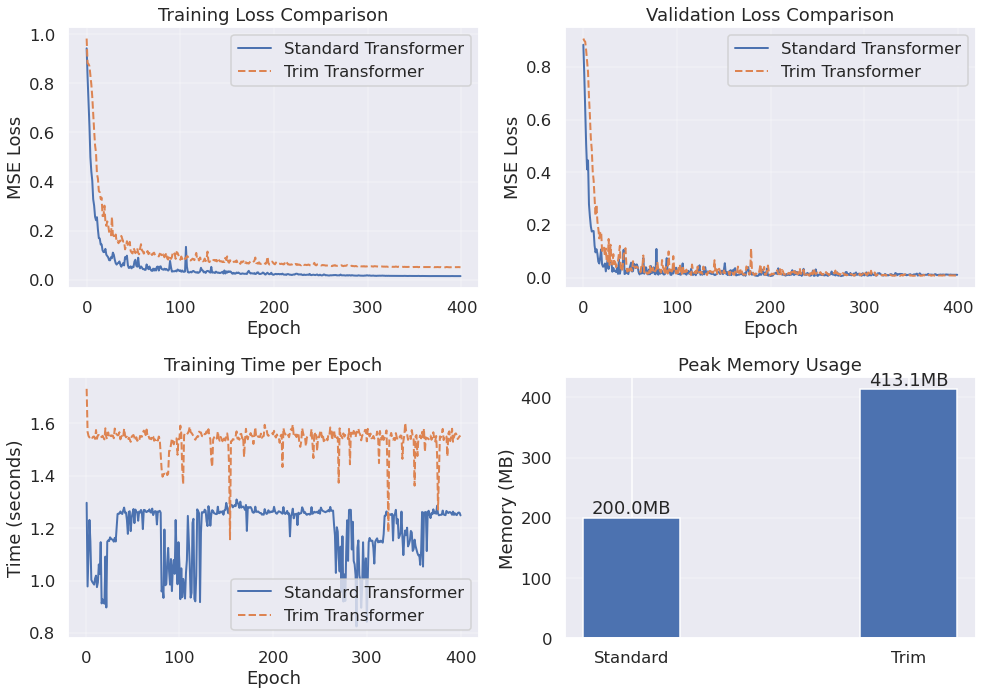

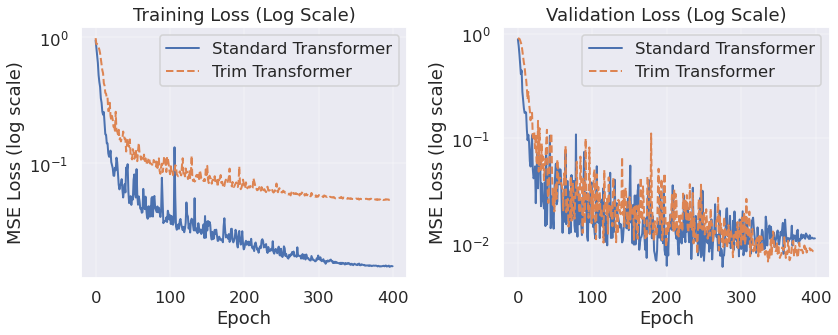

In [8]:
# Plot comparison of training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training loss comparison
ax = axes[0, 0]
ax.plot(results['standard']['train_losses'], label='Standard Transformer', linewidth=2)
ax.plot(results['trim']['train_losses'], label='Trim Transformer', linestyle='--', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation loss comparison
ax = axes[0, 1]
ax.plot(results['standard']['val_losses'], label='Standard Transformer', linewidth=2)
ax.plot(results['trim']['val_losses'], label='Trim Transformer', linestyle='--', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Validation Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Training time per epoch
ax = axes[1, 0]
epochs = range(1, n_epochs + 1)
ax.plot(epochs, results['standard']['epoch_times'], label='Standard Transformer', linewidth=2)
ax.plot(epochs, results['trim']['epoch_times'], label='Trim Transformer', linestyle='--', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training Time per Epoch')
ax.legend()
ax.grid(True, alpha=0.3)

# Memory usage
ax = axes[1, 1]
width = 0.35
models = ['Standard', 'Trim']
mem_values = [max(results['standard']['memory_mb']), max(results['trim']['memory_mb'])]
x = np.arange(len(models))
bars = ax.bar(x, mem_values, width)
ax.set_ylabel('Memory (MB)')
ax.set_title('Peak Memory Usage')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, mem_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}MB', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot log scale comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(results['standard']['train_losses'], label='Standard Transformer', linewidth=2)
plt.semilogy(results['trim']['train_losses'], label='Trim Transformer', linestyle='--', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Training Loss (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(results['standard']['val_losses'], label='Standard Transformer', linewidth=2)
plt.semilogy(results['trim']['val_losses'], label='Trim Transformer', linestyle='--', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Validation Loss (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


\n============================================================
MODEL EVALUATION ON VALIDATION SET
\nStandard Transformer Metrics:
  MSE: 1.592645
  MAE: 1.035335
  RMSE: 1.262000
\nTrim Transformer Metrics:
  MSE: 0.009551
  MAE: 0.076483
  RMSE: 0.097727


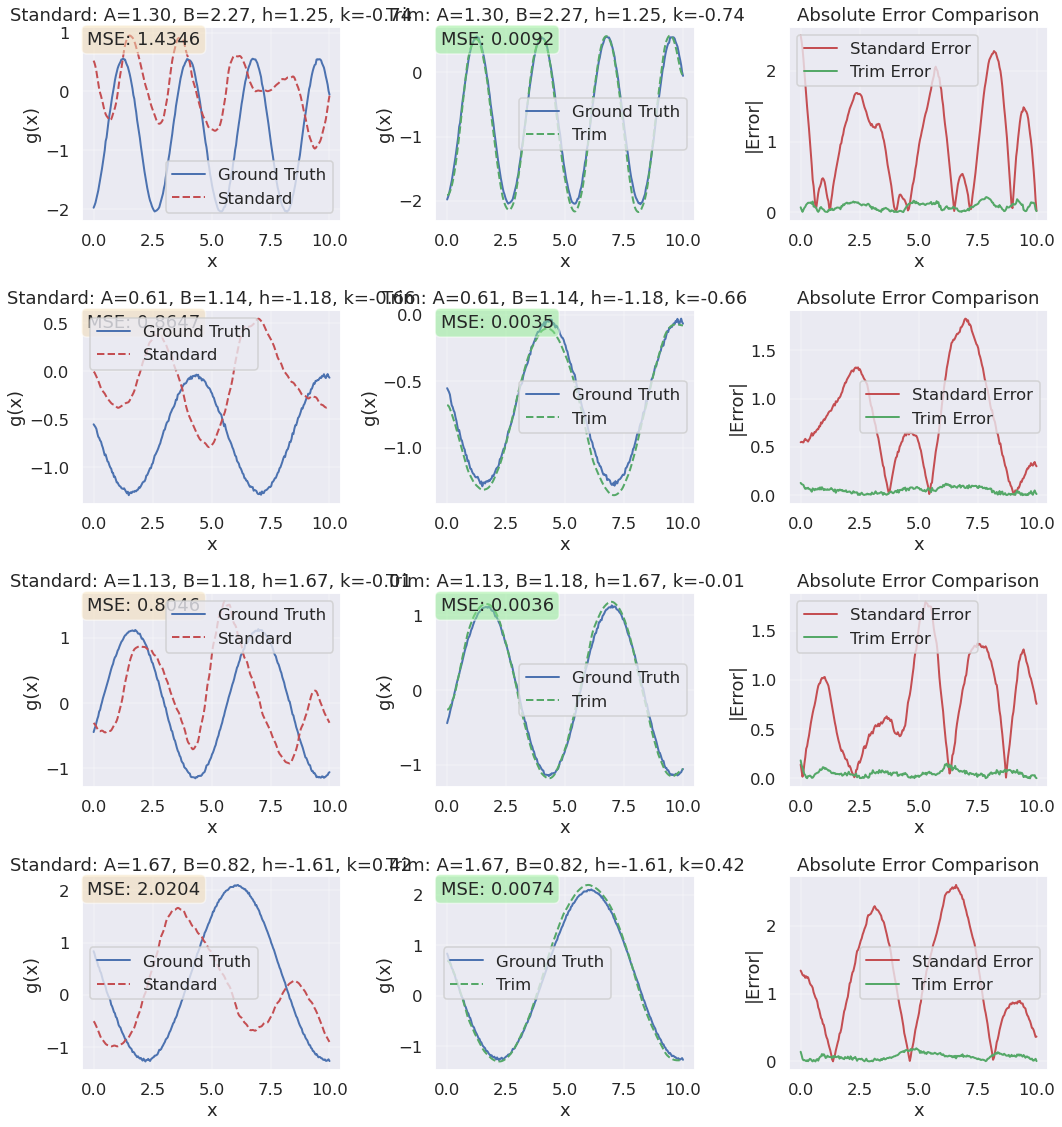

In [9]:
# Evaluate both models on test samples
print("\\n" + "="*60)
print("MODEL EVALUATION ON VALIDATION SET")
print("="*60)

# Get a batch of validation samples
with torch.no_grad():
    val_batch = next(iter(val_loader))
    val_waveforms, val_params = val_batch
    
    # Evaluate each model
    for model_name, pipeline in [("Standard", pipeline_standard), ("Trim", pipeline_trim)]:
        pipeline.eval()
        
        # Make predictions
        predictions = pipeline(val_waveforms, val_params)
        
        # Calculate metrics
        mse = F.mse_loss(predictions, val_waveforms)
        mae = F.l1_loss(predictions, val_waveforms)
        
        print(f"\\n{model_name} Transformer Metrics:")
        print(f"  MSE: {mse.item():.6f}")
        print(f"  MAE: {mae.item():.6f}")
        print(f"  RMSE: {np.sqrt(mse.item()):.6f}")

# Visualize predictions from both models
fig, axes = plt.subplots(4, 3, figsize=(15, 16))

x = np.linspace(0, 10, n_timesteps)

# Evaluate both models
pipeline_standard.eval()
pipeline_trim.eval()

with torch.no_grad():
    pred_standard = pipeline_standard(val_waveforms, val_params)
    pred_trim = pipeline_trim(val_waveforms, val_params)

for i in range(min(4, val_waveforms.shape[0])):
    # Get ground truth and predictions
    gt = val_waveforms[i, :, 0, 0, 0].cpu().numpy()
    pred_s = pred_standard[i, :, 0, 0, 0].cpu().numpy()
    pred_t = pred_trim[i, :, 0, 0, 0].cpu().numpy()
    
    # Get parameters
    A, B, h, k = val_params[i].cpu().numpy()
    
    # Plot ground truth vs standard
    ax = axes[i, 0]
    ax.plot(x, gt, 'b-', label='Ground Truth', linewidth=2)
    ax.plot(x, pred_s, 'r--', label='Standard', linewidth=2)
    ax.set_title(f'Standard: A={A:.2f}, B={B:.2f}, h={h:.2f}, k={k:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('g(x)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calculate and display MSE
    mse_s = np.mean((gt - pred_s) ** 2)
    ax.text(0.02, 0.98, f'MSE: {mse_s:.4f}', 
            transform=ax.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot ground truth vs trim
    ax = axes[i, 1]
    ax.plot(x, gt, 'b-', label='Ground Truth', linewidth=2)
    ax.plot(x, pred_t, 'g--', label='Trim', linewidth=2)
    ax.set_title(f'Trim: A={A:.2f}, B={B:.2f}, h={h:.2f}, k={k:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('g(x)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calculate and display MSE
    mse_t = np.mean((gt - pred_t) ** 2)
    ax.text(0.02, 0.98, f'MSE: {mse_t:.4f}', 
            transform=ax.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # Plot error comparison
    ax = axes[i, 2]
    ax.plot(x, np.abs(gt - pred_s), 'r-', label='Standard Error', linewidth=2)
    ax.plot(x, np.abs(gt - pred_t), 'g-', label='Trim Error', linewidth=2)
    ax.set_title('Absolute Error Comparison')
    ax.set_xlabel('x')
    ax.set_ylabel('|Error|')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Testing on specific parameter combinations:\n


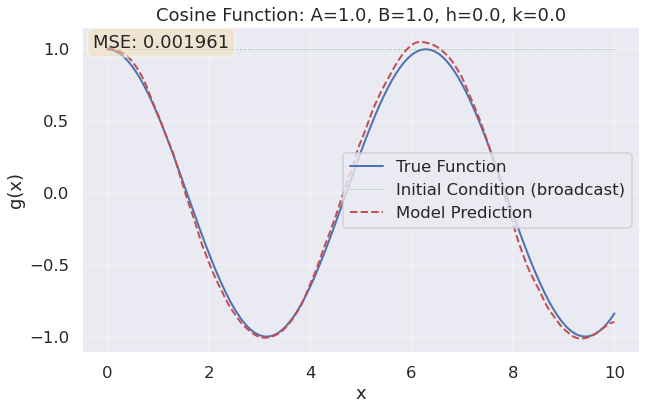

A=1.0, B=1.0, h=0.0, k=0.0 → MSE: 0.001961


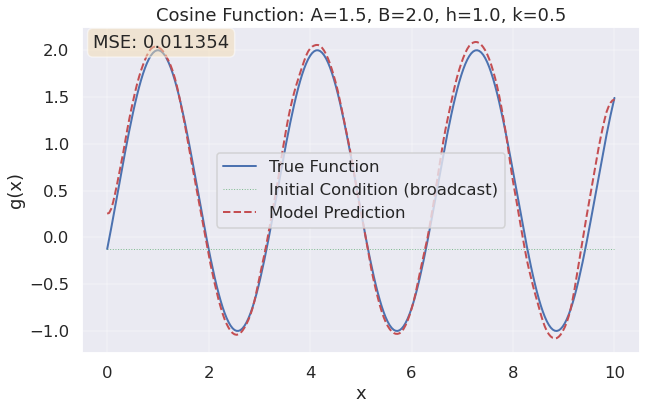

A=1.5, B=2.0, h=1.0, k=0.5 → MSE: 0.011354


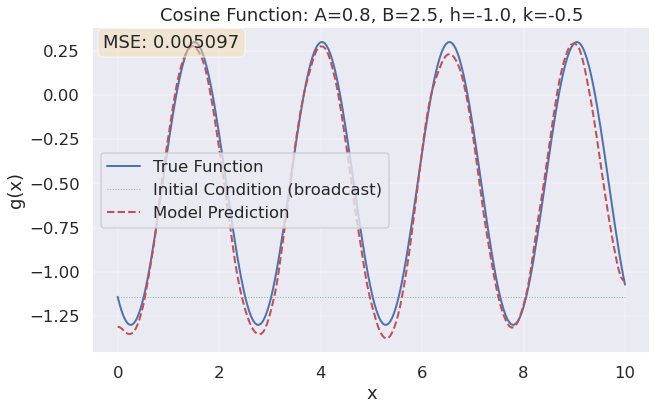

A=0.8, B=2.5, h=-1.0, k=-0.5 → MSE: 0.005097


In [10]:
# Test on specific parameter values
def test_specific_params(A, B, h, k):
    """Test the model on specific cosine function parameters."""
    # Create test data
    x = np.linspace(0, 10, n_timesteps)
    y_true = A * np.cos(B * (x - h)) + k
    
    # Calculate initial condition (value at t=0)
    initial_value = A * np.cos(B * (0 - h)) + k
    
    # Create a constant waveform with just the initial condition
    # This mimics what broadcast_initial_conditions does
    y_initial = np.full(n_timesteps, initial_value)
    
    # Prepare input tensors - use broadcast initial condition as input!
    test_waveform = torch.tensor(y_initial[:, None, None, None], device=device, dtype=torch.float32).unsqueeze(0)
    test_params = torch.tensor([[A, B, h, k]], device=device, dtype=torch.float32)
    
    # Make prediction
    pipeline.eval()
    with torch.no_grad():
        prediction = pipeline(test_waveform, test_params)
    
    # Extract prediction
    y_pred = prediction[0, :, 0, 0, 0].cpu().numpy()
    
    # Calculate error
    mse = np.mean((y_true - y_pred) ** 2)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_true, 'b-', label='True Function', linewidth=2)
    plt.plot(x, y_initial, 'g:', label='Initial Condition (broadcast)', linewidth=1, alpha=0.7)
    plt.plot(x, y_pred, 'r--', label='Model Prediction', linewidth=2)
    plt.title(f'Cosine Function: A={A}, B={B}, h={h}, k={k}')
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.text(0.02, 0.98, f'MSE: {mse:.6f}', 
             transform=plt.gca().transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.show()
    
    return mse

# Test on a few specific examples
print("Testing on specific parameter combinations:\\n")

test_cases = [
    (1.0, 1.0, 0.0, 0.0),  # Simple cosine
    (1.5, 2.0, 1.0, 0.5),  # More complex
    (0.8, 2.5, -1.0, -0.5), # Phase shifted and vertically shifted
]

for A, B, h, k in test_cases:
    mse = test_specific_params(A, B, h, k)
    print(f"A={A}, B={B}, h={h}, k={k} → MSE: {mse:.6f}")


/tmp/ipykernel_5834/3545295612.py:45: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, label='MSE')


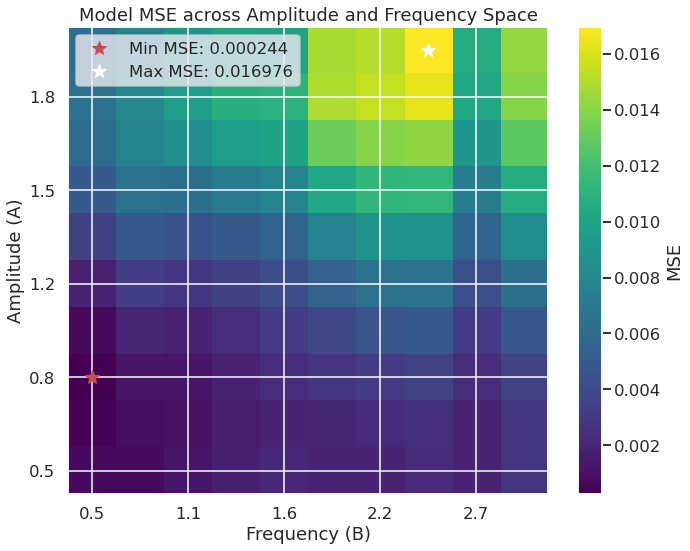

MSE Statistics:
  Minimum: 0.000244
  Maximum: 0.016976
  Mean: 0.006156
  Std: 0.004387


In [11]:
# Analyze model performance across parameter space
def analyze_parameter_sensitivity():
    """Analyze how model performance varies with different parameter values."""
    pipeline.eval()
    
    # Define parameter grids
    n_test = 10
    A_test = np.linspace(0.5, 2.0, n_test)
    B_test = np.linspace(0.5, 3.0, n_test)
    
    # Fixed values for other parameters
    h_fixed = 0.0
    k_fixed = 0.0
    
    # Store MSE values
    mse_grid = np.zeros((n_test, n_test))
    
    x = np.linspace(0, 10, n_timesteps)
    
    with torch.no_grad():
        for i, A in enumerate(A_test):
            for j, B in enumerate(B_test):
                # Generate true function
                y_true = A * np.cos(B * (x - h_fixed)) + k_fixed
                
                # Calculate initial condition and broadcast it
                initial_value = A * np.cos(B * (0 - h_fixed)) + k_fixed
                y_initial = np.full(n_timesteps, initial_value)
                
                # Prepare tensors - use broadcast initial condition as input!
                test_waveform = torch.tensor(y_initial[:, None, None, None], device=device, dtype=torch.float32).unsqueeze(0)
                test_params = torch.tensor([[A, B, h_fixed, k_fixed]], device=device, dtype=torch.float32)
                
                # Predict
                prediction = pipeline(test_waveform, test_params)
                y_pred = prediction[0, :, 0, 0, 0].cpu().numpy()
                
                # Calculate MSE
                mse = np.mean((y_true - y_pred) ** 2)
                mse_grid[i, j] = mse
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    im = plt.imshow(mse_grid, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(im, label='MSE')
    
    # Set axis labels
    plt.xticks(range(0, n_test, 2), [f'{B:.1f}' for B in B_test[::2]])
    plt.yticks(range(0, n_test, 2), [f'{A:.1f}' for A in A_test[::2]])
    plt.xlabel('Frequency (B)')
    plt.ylabel('Amplitude (A)')
    plt.title('Model MSE across Amplitude and Frequency Space')
    
    # Add text annotations for min/max
    min_idx = np.unravel_index(np.argmin(mse_grid), mse_grid.shape)
    max_idx = np.unravel_index(np.argmax(mse_grid), mse_grid.shape)
    
    plt.plot(min_idx[1], min_idx[0], 'r*', markersize=15, label=f'Min MSE: {mse_grid.min():.6f}')
    plt.plot(max_idx[1], max_idx[0], 'w*', markersize=15, label=f'Max MSE: {mse_grid.max():.6f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"MSE Statistics:")
    print(f"  Minimum: {mse_grid.min():.6f}")
    print(f"  Maximum: {mse_grid.max():.6f}")
    print(f"  Mean: {mse_grid.mean():.6f}")
    print(f"  Std: {mse_grid.std():.6f}")

analyze_parameter_sensitivity()
